In [7]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
import sys
import decimal
# training_data = '/data/khandekara2/imputation/training_60.tsv' #training dataset where the minimum read threshold is 60
# training_data_subset = '/data/khandekara2/imputation/training_30_subset.tsv' #training dataset where the minimum read threshold is 30

In [17]:
{'n_estimators': 46,
 'min_samples_split': 2,
 'max_features': 'auto',
 'bootstrap': False}

In [7]:
df = pd.read_csv(training_data_subset, sep='\t')
#add column of read totals and drop unneccessary columns
total_reads = []
for v, t in zip(df['methylated_reads'], df['unmethylated_reads']):
    total_reads.append(int(v + t))
df['total_reads'] = total_reads
df = df[df['total_reads'] <= 80] #we are putting an upper limit on the read depth to guard against copy number variation and sequencing error 
df = df.drop(['#chromosome', 'start', 'stop', 'id', 'methylated_reads', 'unmethylated_reads'], axis=1)

In [8]:
forest = RandomForestRegressor(n_estimators=200, min_samples_split=2, max_features='auto')
y = df['methylation_ratio']
X = df.drop(['methylation_ratio'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
X.head()

,neighbor_ratio,distance,normal_ratio,tumor_average,std_dev,total_reads
0,0.93,51,0.976744,0.90,0.08,37
1,0.63,8,0.947368,0.73,0.23,51
2,0.97,1,0.900000,0.95,0.03,59
3,0.88,35,1.000000,0.89,0.07,58
4,0.95,5,0.939394,0.86,0.10,53


In [9]:
#train and test without optimizing any hyperparameters
forest.fit(X, y)
# predictions = forest.predict(X_test)
# mse = mean_squared_error(y_test, predictions)
# rmse = np.sqrt(mse)
# print (rmse)
# mae = mean_absolute_error(y_test, predictions)
# print (mae)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1]:
# save the model to disk
filename = 'optimized_model_200_trees.pickle'
pickle.dump(forest, open(filename, 'wb')) 

NameError: name 'pickle' is not defined

In [ ]:
forest

In [7]:
X_test['actual'] = y_test
X_test['predictions'] = predictions
# g = sns.lmplot('actual', # Horizontal axis
#            'predictions', # Vertical axis
#            data=X_test, # Data source
#            fit_reg=True, # Don't fix a regression line
#            scatter_kws={"marker": "D", # Set marker style
#                        "s": 20}, line_kws = {'color': 'red'}) # S marker size

print (pearsonr(y_test, predictions))
# ax = plt.gca()
# plt.title('')
# plt.xlabel('Actual Ratio')
# plt.ylabel('Predicted Ratio')
# plt.gcf().text(0.2, 0.85, "pearson r: %.2f" % r_value ** 2, fontsize=10)


(0.8454970176492053, 0.0)


/usr/local/Anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#default hyperparameters
forest.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
#now let's optimize hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

random_search = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=1, random_state=42, refit=True)
random_search.fit(X, y)
final_model = random_search.best_estimator_
pickle.dump(final_model, open('optimized_model.pickle', 'wb')) #save optimized model

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 682.3min finished


In [11]:
# feature_importances = random_search.best_estimator_.feature_importances
random_search.best_params_

{'n_estimators': 46,
 'min_samples_split': 2,
 'max_features': 'auto',
 'bootstrap': False}

In [13]:
random_search.best_score_

0.7480266911682361

In [ ]:
#test optimized model on validation set
forest = pickle.load(open('optimized_model.pickle', 'rb'))
val = pd.read_csv('/data/khandekara2/imputation/validation_set.bed', sep='\t')
total_reads = []
for v, t in zip(val['methylated_reads'], val['unmethylated_reads']):
    total_reads.append(int(v + t))
val['total_reads'] = total_reads
val = val.drop(['chromosome', 'start', 'stop', 'id', 'methylated_reads', 'unmethylated_reads'], axis=1)
y_val = val['methylation_ratio']
X_val = val.drop(['methylation_ratio'], axis=1)
# y_pred = final_model.predict(X_val)
y_pred = forest.predict(X_val)

In [21]:
#compute error metrics 
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print (rmse)
mae = mean_absolute_error(y_val, y_pred)
print (mae)
r2 = r2_score(y_val, y_pred)
print (r2)

0.12565195453998865
0.07912033758053424
0.7522867122812804


In [3]:
#mutated.tsv is final set of mutated sites where we need to impute the methylation ratio
#out-of-sample predictions
mutated = pd.read_csv('/data/khandekara2/imputation/all_single.mutated_2.sorted', sep='\t')
total_reads = []
for v, t in zip(mutated['methylated_reads'], mutated['unmethylated_reads']):
    total_reads.append(int(v + t))
mutated_df = mutated.drop(['methylation_ratio', 'methylated_reads', 'unmethylated_reads', 'chromosome', 'start', 'stop', 'id', 'total_reads', 'variant_reads', 'annotation'], axis=1)
mutated_df['total_reads'] = total_reads
mutated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3869 entries, 0 to 3868
Data columns (total 15 columns):
chromosome            3869 non-null object
start                 3869 non-null int64
stop                  3869 non-null int64
id                    3869 non-null object
methylation_ratio     3869 non-null float64
methylated_reads      3869 non-null float64
unmethylated_reads    3869 non-null float64
neighbor_ratio        3869 non-null float64
distance              3869 non-null int64
normal_ratio          3869 non-null float64
tumor_average         3869 non-null float64
std_dev               3869 non-null float64
total_reads           3869 non-null int64
variant_reads         3869 non-null int64
annotation            3869 non-null object
dtypes: float64(7), int64(5), object(3)
memory usage: 453.5+ KB


In [4]:
#load optimized model and make predictions
forest = pickle.load(open('optimized_model.pickle', 'rb'))
predicted_ratios = forest.predict(mutated_df)
#calculate vaf, prior_ratio, drop, and output file with all the information
actual_ratios = mutated['methylation_ratio']
drop = predicted_ratios - actual_ratios
mutated['drop'] = drop
vafs = []
for v, t in zip(mutated['variant_reads'], mutated['total_reads']):
    vafs.append(float(v) / float(t))
mutated['vaf'] = vafs
mutated['prior_ratio'] = predicted_ratios
mutated.head()


,chromosome,start,stop,id,methylation_ratio,methylated_reads,unmethylated_reads,neighbor_ratio,distance,normal_ratio,tumor_average,std_dev,total_reads,variant_reads,annotation,drop,vaf,prior_ratio
0,chr1,4395757,4395758,tumor_4105105,0.61,31.0,20.0,0.96,12,1.000000,0.90,0.09,33,9,intergenic_region,0.284499,0.272727,0.894499
1,chr1,7575897,7575898,tumor_4105105,0.62,15.0,9.0,0.19,10,0.954545,0.46,0.21,29,13,intron_variant,-0.376036,0.448276,0.243964
2,chr1,16477614,16477615,tumor_4105105,0.52,14.0,13.0,0.48,50,0.807692,0.72,0.21,26,9,upstream_gene_variant,-0.222795,0.346154,0.297205
3,chr1,65691120,65691121,tumor_4105105,0.52,30.0,28.0,0.98,23,0.947368,0.56,0.25,41,21,intron_variant,0.212843,0.512195,0.732843
4,chr1,82792611,82792612,tumor_4105105,0.51,26.0,25.0,0.11,333,0.910714,0.86,0.14,25,14,intergenic_region,0.395691,0.560000,0.905691


In [27]:
#get feature importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(mutated_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.476444)
2. feature 0 (0.154114)
3. feature 2 (0.116096)
4. feature 4 (0.102976)
5. feature 5 (0.097736)
6. feature 1 (0.052635)


In [28]:
mutated_df.head()

,neighbor_ratio,distance,normal_ratio,tumor_average,std_dev,total_reads
0,0.96,12,1.000000,0.90,0.09,51
1,0.19,10,0.954545,0.46,0.21,24
2,0.48,50,0.807692,0.72,0.21,27
3,0.98,23,0.947368,0.56,0.25,58
4,0.11,333,0.910714,0.86,0.14,51


In [15]:
#fix the cases where the drop is negative by taking the max out of the features
fixed_priors = []
for d, p, n, t, nr in zip(mutated['drop'], mutated['prior_ratio'], mutated['neighbor_ratio'], mutated['tumor_average'], mutated['normal_ratio']):
    if d < 0:
        fixed_priors.append(max(n, t, nr))
    else:
        fixed_priors.append(p)
        
mutated['prior_ratio'] = fixed_priors
drop = mutated['prior_ratio'] - actual_ratios
mutated['drop'] = drop

In [20]:
#save output file which contains mutated sites with their reconstructed methylation ratios
mutated.to_csv('/data/khandekara2/imputation/mutations_reconstructed.tsv', sep='\t', index=False)


In [16]:
#check how much noise we have-- i.e if the drop is negative it does not match the mental model 
count = 0
for x in mutated['drop']:
    if x < 0:
#         print (x)
        count += 1
print (count)

38


In [21]:
#get chi-squared statistics now that we have imputed ratios at methylated sites

#We have four categories: 
#1) Methylated and Mutated(mm), 2)Unmethylated and mutated(um) 3)Not mutated and methylated(nm) 4) Not mutated and not methylated(nn) 

#non_mutated whole genome
#since this is a very large file(lots of non-mutated sites), we are going to read it line by line instead of reading the whole thing into a pandas dataframe
with open('/data/khandekara2/imputation/all_single.non_mutated_2_training_30.sorted', 'r') as f:
    nm = 0 #not mutated but methylated
    nn = 0 #not mutated and not methylated
    for line in f:
        row = line.split('\t')
        if float(row[4]) >= 0.1:
            nm += 1
        else:
            nn += 1

#mutated whole genome
mut = pd.read_csv('/data/khandekara2/imputation/mutations_reconstructed.tsv', sep='\t')
mut = mut[mut['drop'] > 0] #filter out sites with negative drop(700 sites)
mm = mut[mut['prior_ratio'] >= 0.1].shape[0]
um = mut[mut['prior_ratio'] < 0.1].shape[0]

#non_mutated cds
# non_mut = pd.read_csv('all_single.non_mutated_cds_2.sorted', sep='\t')
# nm_cds = non_mut[non_mut['methylation_ratio'] >= 0.5].shape[0]
# nn_cds = non_mut[non_mut['methylation_ratio'] < 0.5].shape[0]

# #mutated cds
# mut_cds = pd.read_csv('mutated_cds.bed', sep='\t')
# mm_cds = mut_cds[mut_cds['methylation_ratio'] >= 0.5].shape[0]
# um_cds = mut_cds[mut_cds['methylation_ratio'] < 0.5].shape[0]



In [25]:
print ('Methylated and Mutated: ' + str(mm))
print ('Unmethylated and Mutated: ' + str(um))
print ('Not Mutated and Methylated: ' + str(nm))
print ('Not Mutated and Unmethylated: ' + str(nn))

Methylated and Mutated: 3793
Unmethylated and Mutated: 33
Not Mutated and Methylated: 295851206
Not Mutated and Unmethylated: 7142050


In [22]:
obs = np.array([[mm, nm], [um, nn]])
chi2, p, dof, expected = chi2_contingency(obs)

In [23]:
effect_size = np.sqrt(chi2 / (mm + nm  + um + nn)) #Cramers V
print (effect_size)

0.00034702528659152394


In [40]:
methylated = [i for i in predictions if i >= 0.5]
unmethylated = [i for i in predictions if i < 0.5]
print (len(methylated))
print (len(unmethylated))

2933
936


0.47708234335175764
0.029091872797889107
0.07141529665883871
2.9026909649472268e-64
0.027664409083697526


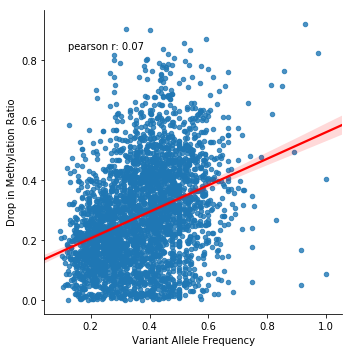

In [11]:
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
slope, intercept, r_value, p_value, std_err = stats.linregress(vafs, drop)
print (slope)
print (intercept)
print (r_value ** 2)
print (p_value)
print (std_err)

m = mutated[mutated['drop'] >= 0]

g = sns.lmplot('vaf', # Horizontal axis
           'drop', # Vertical axis
           data=m, # Data source
           fit_reg=True, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "s": 20}, line_kws = {'color': 'red'}) # S marker size
ax = plt.gca()
plt.title('')
plt.xlabel('Variant Allele Frequency')
plt.ylabel('Drop in Methylation Ratio')
plt.gcf().text(0.2, 0.85, "pearson r: %.2f" % r_value ** 2, fontsize=10)
plt.savefig('vaf_vs_drop.png', dpi=600)

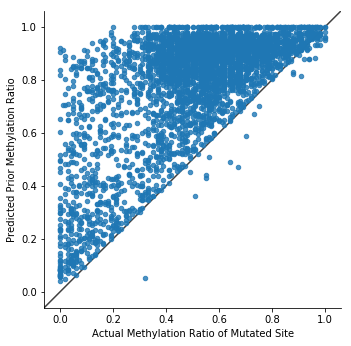

In [24]:
g = sns.lmplot('methylation_ratio', # Horizontal axis
           'prior_ratio', # Vertical axis
           data=mutated, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "s": 20}) # S marker size
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.title('')
plt.xlabel('Actual Methylation Ratio of Mutated Site')
plt.ylabel('Predicted Prior Methylation Ratio')
plt.savefig('actual_vs_prior.png', dpi=600)

/usr/local/Anaconda/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


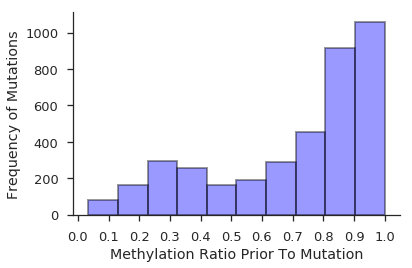

In [61]:
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# params = {
#    'axes.labelsize': 6,
#    'font.size': 6,
#    'legend.fontsize': 6,
#    'xtick.labelsize': 6,
#    'ytick.labelsize': 6,
#    'text.usetex': False,
#    'figure.figsize': [3, 2] # instead of 4.5, 4.5
#    }
# plt.rcParams.update(params)
# sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.set_context("talk")
binzz = [x for x in np.arange(0, 1.1, 0.1)]
plt.xticks(binzz)
sns_plot = sns.distplot(predicted_ratios, kde=False, rug=False, color='blue', bins=10, hist_kws=dict(edgecolor="k", linewidth=2))
sns.despine()
plt.xlabel('Methylation Ratio Prior To Mutation')
plt.ylabel('Frequency of Mutations')
# plt.title('Methylation Levels of All Mutated CpG Sites in MALY')
plt.tight_layout()
plt.savefig('prior_ratio_histogram.png', dpi=600)

In [22]:
#now calculate effect size

3869


numpy.float64

In [27]:
predicted_ratios = [round(x, 2) for x in predicted_ratios]
mutated['prior_ratio'] = predicted_ratios

725


In [ ]:
mutated.info()

In [ ]:
#check the error if we just guessed the average methylation of the genome..it should be greater than the error from our model
average = [0.65 for i in y_test]
rmse2 = np.sqrt(mean_squared_error(y_test, average))
print (rmse2)
#check error if we just used one feature at a time
rmse3 = np.sqrt(mean_squared_error(y, df['neighbor_ratio']))
rmse4 = np.sqrt(mean_squared_error(y, df['tumor_average']))
rmse5 = np.sqrt(mean_squared_error(y, df['normal_ratio'])) 
print (rmse2)
print (rmse3)
print (rmse4)
print (rmse5)
print (rmse_low)
print (rmse_intermediate)
print (rmse_high)